## Setup and Installation

In [1]:
%%capture
!pip install datasets --upgrade
!pip install transformers[torch]
!pip install torch
!pip install transformers -U
!pip install transformers datasets evaluate
!pip install librosa

In [ ]:
%%capture
!apt install git-lfs

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("audio_classification_notebook", framework="pytorch")

- Log in using your hugging face access token.
- Go to Profil -> Access Token

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load The Data Set

- Here, I use the dataset from https://huggingface.co/datasets/PolyAI/minds14 with subses 'en-AU'

In [ ]:
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-AU/*'

from datasets import load_dataset, load_metric, Audio

ds_train = load_dataset('./en-AU', split="train")
metric = load_metric("accuracy")

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Fetching 2 files:   0% 0/2 [00:00<?, ?it/s]downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36c2fc04fda5de3bdd70cf/en-AU/train/0000.parquet to /root/.cache/huggingface/hub/tmp9_zenyp2
downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36c2fc04fda5de3bdd70cf/en-AU/train/index.duckdb to /root/.cache/huggingface/hub/tmpdrr_153e

0000.parquet:   0% 0.00/37.4M [00:00<?, ?B/s]
0000.parquet:  56% 21.0M/37.4M [00:00<00:00, 138MB/s]
0000.parquet: 100% 37.4M/37.4M [00:00<00:00, 142MB/s]
Fetching 2 files:  50% 1/2 [00:00<00:00,  1.10it/s]
index.duckdb:   0% 0.00/33.6M [00:00<?, ?B/s]
index.duckdb: 100% 33.6M/33.6M [00:00<00:00, 233MB/s]
Fetching 2 files: 100% 2/2 [00:01<00:00,  1.15it/s]
/content


Generating train split: 0 examples [00:00, ? examples/s]

<ipython-input-6-1ad343353646>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
#Remove unnecessary columns

ds_train = ds_train.remove_columns(["path", "transcription", "english_transcription", "lang_id"])

In [ ]:
ds_train

Dataset({
    features: ['audio', 'intent_class'],
    num_rows: 654
})

### Split Data into Train and Test

In [ ]:
ds_train_split = ds_train.train_test_split(test_size=0.2)

In [ ]:
ds_train_split

DatasetDict({
    train: Dataset({
        features: ['audio', 'intent_class'],
        num_rows: 523
    })
    test: Dataset({
        features: ['audio', 'intent_class'],
        num_rows: 131
    })
})

In [ ]:
ds_train_split = ds_train_split.cast_column("audio", Audio(sampling_rate=16_000))
ds_train_split["train"][0]

{'audio': {'path': 'response_39.wav',
  'array': array([ 2.27752840e-04,  1.24971848e-04,  1.68168917e-05, ...,
         -6.08638488e-03, -3.79715487e-03, -1.59078976e-03]),
  'sampling_rate': 16000},
 'intent_class': 4}

In [ ]:
ds_train_split["test"][0]

{'audio': {'path': 'response_40.wav',
  'array': array([ 2.02721567e-05,  6.13949960e-05, -2.05730903e-05, ...,
         -1.98931855e-04,  2.53279461e-04,  1.98464462e-04]),
  'sampling_rate': 16000},
 'intent_class': 9}

### Mapping

In [ ]:
labels = ds_train_split["train"].features["intent_class"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label[str(13)]

'pay_bill'

In [ ]:
ds_train_split["test"][0]["audio"]

{'path': 'response_40.wav',
 'array': array([ 2.02721567e-05,  6.13949960e-05, -2.05730903e-05, ...,
        -1.98931855e-04,  2.53279461e-04,  1.98464462e-04]),
 'sampling_rate': 16000}

## Visualization

- Wave Plot and Spectogram

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings

warnings.filterwarnings('ignore')

Intent Class: freeze
Shape: (72362,), sampling rate: 16000


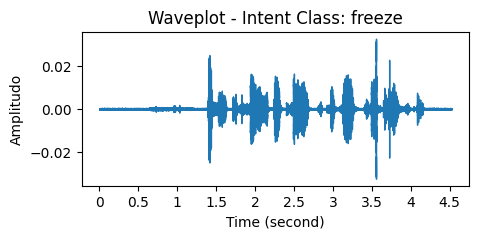

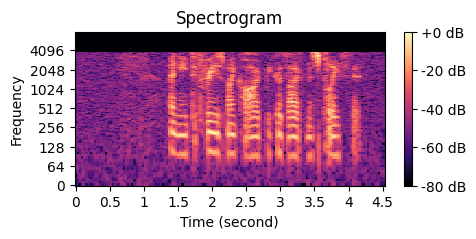


Intent Class: atm_limit
Shape: (81920,), sampling rate: 16000


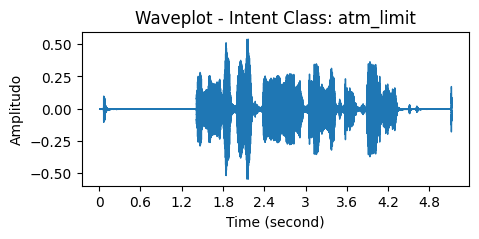

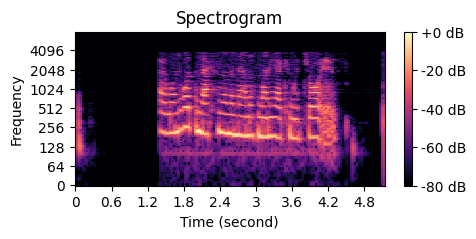


Intent Class: business_loan
Shape: (86016,), sampling rate: 16000


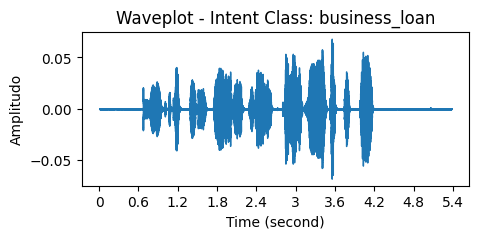

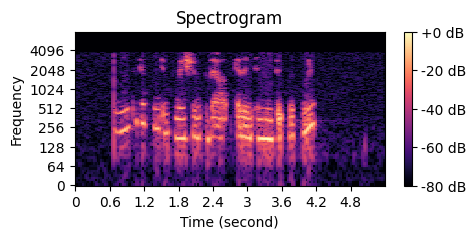


Intent Class: address
Shape: (80554,), sampling rate: 16000


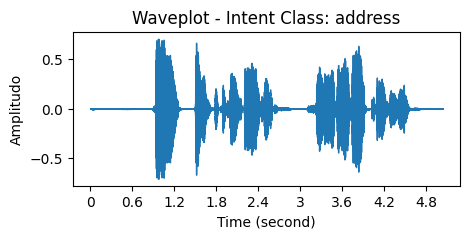

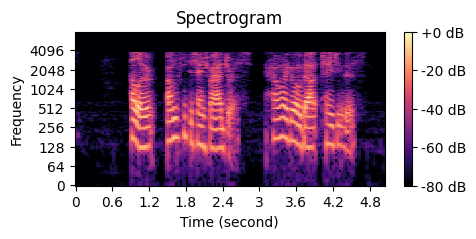


Intent Class: business_loan
Shape: (98240,), sampling rate: 16000


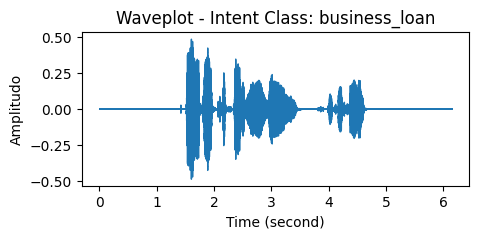

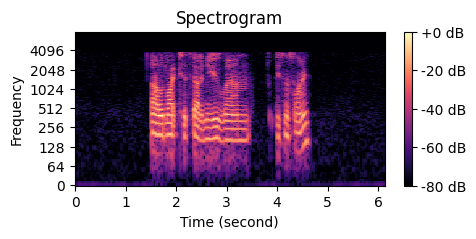

In [ ]:
for _ in range(5):
    rand_idx = random.randint(0, len(ds_train_split["train"])-1)
    example = ds_train_split["train"][rand_idx]
    audio = example["audio"]

    print(f'Intent Class: {id2label[str(example["intent_class"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')

    # Display Waveplot
    plt.figure(figsize=(5, 2))
    librosa.display.waveshow(audio["array"], sr=audio["sampling_rate"])
    plt.title(f'Waveplot - Intent Class: {id2label[str(example["intent_class"])]}')
    plt.xlabel('Time (second)')
    plt.ylabel('Amplitudo')
    plt.show()

    # Display Spectrogram
    plt.figure(figsize=(5, 2))
    librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio["array"]), ref=np.max), y_axis='log', x_axis='time', sr=audio["sampling_rate"])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (second)')
    plt.ylabel('Frequency')
    plt.show()

    # Display Audio
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()


## Preprocessing Data

In [ ]:
model_checkpoint = "facebook/wav2vec2-base-960h"
batch_size = 128

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
max_duration = 1.0  # seconds

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

In [ ]:
preprocess_function(ds_train_split['train'][:5])

{'input_values': [array([ 0.06775258,  0.03558519,  0.00173592, ..., -0.0785651 ,
       -0.07926535, -0.02436237], dtype=float32), array([-0.00144057, -0.0008001 , -0.0049456 , ...,  0.00532649,
        0.0416329 ,  0.06533474], dtype=float32), array([ 1.5352494e-05, -6.9620577e-04,  7.8793650e-04, ...,
        1.8480511e-01,  1.7581074e-01,  1.4468239e-01], dtype=float32), array([-0.00480775, -0.00385319,  0.00068532, ..., -0.12730986,
       -0.22320232, -0.3444177 ], dtype=float32), array([0.00093452, 0.00188813, 0.00084425, ..., 0.26208326, 0.2696518 ,
       0.24947517], dtype=float32)]}

In [ ]:
encoded_dataset = ds_train_split.map(preprocess_function, remove_columns="audio", batched=True)
encoded_dataset = encoded_dataset.rename_column("intent_class", "label")

Map:   0%|          | 0/523 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

## Training The Model

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'classifier.weight', 'wav2vec2.masked_spec_embed', 'projector.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.2,
    logging_steps=2,
    warmup_steps=10,
    max_steps=30,
    save_steps=30,
    eval_steps=30,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True
)

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.637906,0.083969
2,1.319300,2.637691,0.083969
3,1.153600,2.637384,0.076336
4,0.825500,2.637684,0.076336
5,0.824700,2.639013,0.076336
6,0.824700,2.638716,0.083969
7,1.153600,2.641521,0.099237
8,1.318300,2.640816,0.091603
9,1.318300,2.640152,0.099237
10,1.317600,2.641393,0.099237


Checkpoint destination directory wav2vec2-base-960h-finetuned-ks/checkpoint-1 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory wav2vec2-base-960h-finetuned-ks/checkpoint-3 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory wav2vec2-base-960h-finetuned-ks/checkpoint-4 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory wav2vec2-base-960h-finetuned-ks/checkpoint-6 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory wav2vec2-base-960h-finetuned-ks/checkpoint-8 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory wav2vec2-base-960h-finetuned-ks/checkpoint-9 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint desti

TrainOutput(global_step=30, training_loss=1.0977883060773215, metrics={'train_runtime': 476.9151, 'train_samples_per_second': 64.414, 'train_steps_per_second': 0.063, 'total_flos': 9.496559424384e+16, 'train_loss': 1.0977883060773215, 'epoch': 20.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 2.644860029220581,
 'eval_accuracy': 0.10687022900763359,
 'eval_runtime': 1.5278,
 'eval_samples_per_second': 85.743,
 'eval_steps_per_second': 1.309,
 'epoch': 20.0}

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1703169856.1f242e286bb5.492.2:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1703170346.1f242e286bb5.492.3:   0%|          | 0.00/405 [00:00<?, ?B/s]

'https://huggingface.co/tataun/wav2vec2-base-960h-finetuned-ks/tree/main/'